### Hugging face login

In [ ]:
from huggingface_hub import login

login()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\datainsight\.cache\huggingface\token
Login successful


In [2]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download CRC-100K (No Norm)

You can download the CRC-100K ROI dataset at the following link: https://zenodo.org/records/1214456, which is a 9-class colorectal tissue classification task.
- Train (100K images, 11.7 GB): https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K-NONORM.zip?download=1
- Test (7.180K images, 800.3 MB): https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip?download=1

Once you download these *.zip files, you can unzup them in your local directory (this example puts it in the `UNI/assets/data/CRC100K` relative path of the GitHub repository). The organization of these folders follows the the `torchvision.datasets.ImageFolder` structure, where the subfolders are labeled by the object class, and the images in each folder are of the same class.


In [3]:
dataroot = "D:\Aamir Gulzar\dataset\CRC100K"
assert os.path.isdir(r"D:\Aamir Gulzar\dataset\CRC100K\NCT-CRC-HE-100K-NONORM")
assert os.path.isdir(r"D:\Aamir Gulzar\dataset\CRC100K\CRC-VAL-HE-7K")

### Data Loaders

### 224X224 crc100k 

In [4]:
import time
import torchvision.transforms as transforms
# get path to example data
start = time.time()
dataroot = "D:\Aamir Gulzar\dataset\CRC100K"
transform = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.ToTensor()
])


# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# create some image folder datasets for train/test and their data laoders
import torchvision
import os

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

In [5]:
labels_dict = train_dataset.class_to_idx
print(labels_dict)

{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


### Unique Class Print

In [6]:
def print_unique_class_representation(train_loader, test_loader):
    def get_unique_classes(loader):
        all_labels = []
        for _, labels in loader:
            all_labels.extend(labels.tolist())
        unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)
        return unique_labels, counts

    train_unique_labels, train_counts = get_unique_classes(train_loader)
    # val_unique_labels, val_counts = get_unique_classes(val_loader)
    test_unique_labels, test_counts = get_unique_classes(test_loader)

    print("Train Loader Unique Labels and Counts:")
    print(f"Unique labels: {train_unique_labels}")
    print(f"Counts: {train_counts}")

    # print("\nValidation Loader Unique Labels and Counts:")
    # print(f"Unique labels: {val_unique_labels}")
    # print(f"Counts: {val_counts}")

    print("\nTest Loader Unique Labels and Counts:")
    print(f"Unique labels: {test_unique_labels}")
    print(f"Counts: {test_counts}")

# Example usage:
# print_unique_class_representation(train_dataloader, test_dataloader)
for batch_idx, (images, labels) in enumerate(test_dataloader):
    print(f"Batch {batch_idx}: {len(images)} images")
    print(f"Images shape: {images.shape}")
    unique_labels, counts = torch.unique(labels, return_counts=True)
    print(f"Unique labels: {unique_labels}")
    print(f"Counts: {counts}")
    if batch_idx == 2:  # Only print a few batches to check if it's working
        break

Batch 0: 256 images
Images shape: torch.Size([256, 3, 224, 224])
Unique labels: tensor([0])
Counts: tensor([256])
Batch 1: 256 images
Images shape: torch.Size([256, 3, 224, 224])
Unique labels: tensor([0])
Counts: tensor([256])
Batch 2: 256 images
Images shape: torch.Size([256, 3, 224, 224])
Unique labels: tensor([0])
Counts: tensor([256])


## Loading H-optimus

## 1. CRC data Feature Extraction using H-optimus
1. Downloading H-optimus weights + Creating Model
2. The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.


In [ ]:
import torch
import timm
from PIL import Image
from torchvision import transforms
from huggingface_hub import login
from typing import List, Union


import torch
import timm
from torchvision import transforms
from typing import List
from PIL import Image
from tqdm import tqdm
from huggingface_hub import login


class HOptimusExtractor:
    def __init__(self, device: str = 'cuda'):
        # Hugging Face login
        login()

        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Load model once
        self.model = timm.create_model(
            "hf-hub:bioptimus/H-optimus-1",
            pretrained=True,
            init_values=1e-5,
            dynamic_img_size=False
        ).to(self.device).eval()

        # Fixed transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.707223, 0.578729, 0.703617),
                std=(0.211883, 0.230117, 0.177517)
            )
        ])



    def extract_features_from_paths(
            self,
            paths: List[str],
            batch_size: int = 256
        ) -> torch.Tensor:
        """
        Extract features for many image paths efficiently.
        Supports .tif/.tiff via PIL.
        Returns stacked tensor (N, feature_dim) on CPU.
        """
        all_feats = []
        device = self.device
        use_autocast = (device.type == "cuda")
    
        with torch.inference_mode():
            for start in tqdm(range(0, len(paths), batch_size), desc="🔍 Extracting", unit="batch"):
                batch_start_time = time.time()
    
                batch_paths = paths[start:start + batch_size]
    
                # Image loading & transformation
                imgs = [self.transform(Image.open(p).convert("RGB")) for p in batch_paths]
    
                # Tensor stacking & transfer
                batch_tensor = torch.stack(imgs, dim=0).to(device, non_blocking=True)
    
                # Model forward pass
                if use_autocast:
                    with torch.autocast(device_type="cuda", dtype=torch.float16):
                        feats = self.model(batch_tensor)
                else:
                    feats = self.model(batch_tensor)
    
                all_feats.append(feats.cpu())
    
                # Batch total time
                batch_total_time = time.time() - batch_start_time
    
                print(
                    f"Total {batch_total_time:.2f}s"
                )
    
        return torch.cat(all_feats, dim=0)
    


In [8]:
def extract_patch_features_hoptimus(extractor, dataloader):
    all_embeddings, all_labels = [], []

    all_paths = [path for path, _ in dataloader.dataset.samples]
    all_targets = [label for _, label in dataloader.dataset.samples]
    # return all_paths

    features = extractor.extract_features_from_paths(all_paths, batch_size=dataloader.batch_size)
    all_embeddings = features
    all_labels = np.array(all_targets)

    return {
        "embeddings": all_embeddings.cpu().numpy().astype(np.float32),
        "labels": all_labels
    }

In [9]:
from tqdm import tqdm

extractor = HOptimusExtractor()
train_features_hopt = extract_patch_features_hoptimus(extractor, train_dataloader)
test_features_hopt  = extract_patch_features_hoptimus(extractor, test_dataloader)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\datainsight\.cache\huggingface\token
Login successful


🔍 Extracting:   0%|                                                                        | 0/391 [00:00<?, ?batch/s]C:\Users\datainsight\anaconda3\envs\exaonepath\lib\site-packages\timm\layers\attention.py:80: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
🔍 Extracting:   0%|▏                                                               | 1/391 [00:03<25:05,  3.86s/batch]

Total 3.86s


🔍 Extracting:   1%|▎                                                               | 2/391 [00:07<23:43,  3.66s/batch]

Total 3.52s


🔍 Extracting:   1%|▍                                                               | 3/391 [00:10<23:09,  3.58s/batch]

Total 3.49s


🔍 Extracting:   1%|▋                                                               | 4/391 [00:14<22:52,  3.55s/batch]

Total 3.49s


🔍 Extracting:   1%|▊                                                               | 5/391 [00:17<22:20,  3.47s/batch]

Total 3.34s


🔍 Extracting:   2%|▉                                                               | 6/391 [00:21<22:18,  3.48s/batch]

Total 3.48s


🔍 Extracting:   2%|█▏                                                              | 7/391 [00:24<22:02,  3.44s/batch]

Total 3.37s


🔍 Extracting:   2%|█▎                                                              | 8/391 [00:33<33:48,  5.30s/batch]

Total 9.27s


🔍 Extracting:   2%|█▍                                                              | 9/391 [00:40<36:11,  5.69s/batch]

Total 6.54s


🔍 Extracting:   3%|█▌                                                             | 10/391 [00:43<31:24,  4.95s/batch]

Total 3.29s


🔍 Extracting:   3%|█▊                                                             | 11/391 [00:47<28:36,  4.52s/batch]

Total 3.55s


🔍 Extracting:   3%|█▉                                                             | 12/391 [00:50<26:24,  4.18s/batch]

Total 3.41s


🔍 Extracting:   3%|██                                                             | 13/391 [00:54<24:58,  3.96s/batch]

Total 3.46s


🔍 Extracting:   4%|██▎                                                            | 14/391 [00:57<23:52,  3.80s/batch]

Total 3.42s


🔍 Extracting:   4%|██▍                                                            | 15/391 [01:00<23:13,  3.71s/batch]

Total 3.48s


🔍 Extracting:   4%|██▌                                                            | 16/391 [01:04<22:35,  3.61s/batch]

Total 3.40s


🔍 Extracting:   4%|██▋                                                            | 17/391 [01:07<22:17,  3.58s/batch]

Total 3.49s


🔍 Extracting:   5%|██▉                                                            | 18/391 [01:11<21:52,  3.52s/batch]

Total 3.39s


🔍 Extracting:   5%|███                                                            | 19/391 [01:14<21:45,  3.51s/batch]

Total 3.48s


🔍 Extracting:   5%|███▏                                                           | 20/391 [01:18<21:46,  3.52s/batch]

Total 3.55s


🔍 Extracting:   5%|███▍                                                           | 21/391 [01:21<21:42,  3.52s/batch]

Total 3.52s


🔍 Extracting:   6%|███▌                                                           | 22/391 [01:25<21:52,  3.56s/batch]

Total 3.65s


🔍 Extracting:   6%|███▋                                                           | 23/391 [01:28<21:40,  3.53s/batch]

Total 3.48s


🔍 Extracting:   6%|███▊                                                           | 24/391 [01:32<21:46,  3.56s/batch]

Total 3.61s


🔍 Extracting:   6%|████                                                           | 25/391 [01:36<21:32,  3.53s/batch]

Total 3.46s


🔍 Extracting:   7%|████▏                                                          | 26/391 [01:39<21:26,  3.53s/batch]

Total 3.51s


🔍 Extracting:   7%|████▎                                                          | 27/391 [01:42<21:09,  3.49s/batch]

Total 3.40s


🔍 Extracting:   7%|████▌                                                          | 28/391 [01:46<21:06,  3.49s/batch]

Total 3.49s


🔍 Extracting:   7%|████▋                                                          | 29/391 [01:49<21:02,  3.49s/batch]

Total 3.49s


🔍 Extracting:   8%|████▊                                                          | 30/391 [01:53<21:05,  3.51s/batch]

Total 3.55s


🔍 Extracting:   8%|████▉                                                          | 31/391 [01:56<20:58,  3.49s/batch]

Total 3.47s


🔍 Extracting:   8%|█████▏                                                         | 32/391 [02:00<20:55,  3.50s/batch]

Total 3.50s


🔍 Extracting:   8%|█████▎                                                         | 33/391 [02:03<20:51,  3.50s/batch]

Total 3.49s


🔍 Extracting:   9%|█████▍                                                         | 34/391 [02:07<20:43,  3.48s/batch]

Total 3.45s


🔍 Extracting:   9%|█████▋                                                         | 35/391 [02:10<20:38,  3.48s/batch]

Total 3.47s


🔍 Extracting:   9%|█████▊                                                         | 36/391 [02:14<20:37,  3.48s/batch]

Total 3.50s


🔍 Extracting:   9%|█████▉                                                         | 37/391 [02:17<20:36,  3.49s/batch]

Total 3.51s


🔍 Extracting:  10%|██████                                                         | 38/391 [02:21<20:24,  3.47s/batch]

Total 3.41s


🔍 Extracting:  10%|██████▎                                                        | 39/391 [02:24<20:14,  3.45s/batch]

Total 3.41s


🔍 Extracting:  10%|██████▍                                                        | 40/391 [02:28<20:07,  3.44s/batch]

Total 3.42s


🔍 Extracting:  10%|██████▌                                                        | 41/391 [02:31<20:11,  3.46s/batch]

Total 3.51s


🔍 Extracting:  11%|██████▊                                                        | 42/391 [02:35<20:08,  3.46s/batch]

Total 3.46s


🔍 Extracting:  11%|██████▉                                                        | 43/391 [02:38<20:11,  3.48s/batch]

Total 3.52s


🔍 Extracting:  11%|███████                                                        | 44/391 [02:41<19:58,  3.45s/batch]

Total 3.39s


🔍 Extracting:  12%|███████▎                                                       | 45/391 [02:45<20:12,  3.50s/batch]

Total 3.62s


🔍 Extracting:  12%|███████▍                                                       | 46/391 [02:49<19:57,  3.47s/batch]

Total 3.39s


🔍 Extracting:  12%|███████▌                                                       | 47/391 [02:52<20:01,  3.49s/batch]

Total 3.54s


🔍 Extracting:  12%|███████▋                                                       | 48/391 [02:56<19:55,  3.48s/batch]

Total 3.47s


🔍 Extracting:  13%|███████▉                                                       | 49/391 [02:59<19:44,  3.46s/batch]

Total 3.42s


🔍 Extracting:  13%|████████                                                       | 50/391 [03:02<19:51,  3.49s/batch]

Total 3.56s


🔍 Extracting:  13%|████████▏                                                      | 51/391 [03:06<19:40,  3.47s/batch]

Total 3.42s


🔍 Extracting:  13%|████████▍                                                      | 52/391 [03:09<19:40,  3.48s/batch]

Total 3.51s


🔍 Extracting:  14%|████████▌                                                      | 53/391 [03:13<19:36,  3.48s/batch]

Total 3.48s


🔍 Extracting:  14%|████████▋                                                      | 54/391 [03:16<19:32,  3.48s/batch]

Total 3.47s


🔍 Extracting:  14%|████████▊                                                      | 55/391 [03:20<19:25,  3.47s/batch]

Total 3.44s


🔍 Extracting:  14%|█████████                                                      | 56/391 [03:23<19:29,  3.49s/batch]

Total 3.54s


🔍 Extracting:  15%|█████████▏                                                     | 57/391 [03:27<19:20,  3.48s/batch]

Total 3.44s


🔍 Extracting:  15%|█████████▎                                                     | 58/391 [03:30<19:18,  3.48s/batch]

Total 3.49s


🔍 Extracting:  15%|█████████▌                                                     | 59/391 [03:34<19:11,  3.47s/batch]

Total 3.44s


🔍 Extracting:  15%|█████████▋                                                     | 60/391 [03:37<19:09,  3.47s/batch]

Total 3.48s


🔍 Extracting:  16%|█████████▊                                                     | 61/391 [03:41<19:08,  3.48s/batch]

Total 3.49s


🔍 Extracting:  16%|█████████▉                                                     | 62/391 [03:44<19:02,  3.47s/batch]

Total 3.46s


🔍 Extracting:  16%|██████████▏                                                    | 63/391 [03:48<18:47,  3.44s/batch]

Total 3.35s


🔍 Extracting:  16%|██████████▎                                                    | 64/391 [03:51<18:37,  3.42s/batch]

Total 3.38s


🔍 Extracting:  17%|██████████▍                                                    | 65/391 [03:54<18:36,  3.43s/batch]

Total 3.44s


🔍 Extracting:  17%|██████████▋                                                    | 66/391 [03:58<18:42,  3.45s/batch]

Total 3.52s


🔍 Extracting:  17%|██████████▊                                                    | 67/391 [04:01<18:39,  3.45s/batch]

Total 3.46s


🔍 Extracting:  17%|██████████▉                                                    | 68/391 [04:05<18:34,  3.45s/batch]

Total 3.44s


🔍 Extracting:  18%|███████████                                                    | 69/391 [04:08<18:32,  3.45s/batch]

Total 3.46s


🔍 Extracting:  18%|███████████▎                                                   | 70/391 [04:12<18:34,  3.47s/batch]

Total 3.51s


🔍 Extracting:  18%|███████████▍                                                   | 71/391 [04:15<18:27,  3.46s/batch]

Total 3.44s


🔍 Extracting:  18%|███████████▌                                                   | 72/391 [04:19<18:30,  3.48s/batch]

Total 3.53s


🔍 Extracting:  19%|███████████▊                                                   | 73/391 [04:22<18:14,  3.44s/batch]

Total 3.35s


🔍 Extracting:  19%|███████████▉                                                   | 74/391 [04:26<18:19,  3.47s/batch]

Total 3.53s


🔍 Extracting:  19%|████████████                                                   | 75/391 [04:29<18:10,  3.45s/batch]

Total 3.41s


🔍 Extracting:  19%|████████████▏                                                  | 76/391 [04:33<18:17,  3.48s/batch]

Total 3.56s


🔍 Extracting:  20%|████████████▍                                                  | 77/391 [04:36<18:10,  3.47s/batch]

Total 3.45s


🔍 Extracting:  20%|████████████▌                                                  | 78/391 [04:39<18:08,  3.48s/batch]

Total 3.48s


🔍 Extracting:  20%|████████████▋                                                  | 79/391 [04:43<17:53,  3.44s/batch]

Total 3.36s


🔍 Extracting:  20%|████████████▉                                                  | 80/391 [04:46<17:55,  3.46s/batch]

Total 3.50s


🔍 Extracting:  21%|█████████████                                                  | 81/391 [04:50<17:45,  3.44s/batch]

Total 3.38s


🔍 Extracting:  21%|█████████████▏                                                 | 82/391 [04:53<17:43,  3.44s/batch]

Total 3.45s


🔍 Extracting:  21%|█████████████▎                                                 | 83/391 [04:57<17:42,  3.45s/batch]

Total 3.47s


🔍 Extracting:  21%|█████████████▌                                                 | 84/391 [05:00<17:36,  3.44s/batch]

Total 3.42s


🔍 Extracting:  22%|█████████████▋                                                 | 85/391 [05:04<17:40,  3.47s/batch]

Total 3.52s


🔍 Extracting:  22%|█████████████▊                                                 | 86/391 [05:07<17:29,  3.44s/batch]

Total 3.38s


🔍 Extracting:  22%|██████████████                                                 | 87/391 [05:11<17:34,  3.47s/batch]

Total 3.53s


🔍 Extracting:  23%|██████████████▏                                                | 88/391 [05:14<17:26,  3.45s/batch]

Total 3.41s


🔍 Extracting:  23%|██████████████▎                                                | 89/391 [05:17<17:20,  3.44s/batch]

Total 3.42s


🔍 Extracting:  23%|██████████████▌                                                | 90/391 [05:21<17:12,  3.43s/batch]

Total 3.39s


🔍 Extracting:  23%|██████████████▋                                                | 91/391 [05:24<17:07,  3.43s/batch]

Total 3.42s


🔍 Extracting:  24%|██████████████▊                                                | 92/391 [05:28<17:09,  3.44s/batch]

Total 3.48s


🔍 Extracting:  24%|██████████████▉                                                | 93/391 [05:31<17:02,  3.43s/batch]

Total 3.40s


🔍 Extracting:  24%|███████████████▏                                               | 94/391 [05:34<17:00,  3.44s/batch]

Total 3.45s


🔍 Extracting:  24%|███████████████▎                                               | 95/391 [05:38<16:48,  3.41s/batch]

Total 3.34s


🔍 Extracting:  25%|███████████████▍                                               | 96/391 [05:41<16:54,  3.44s/batch]

Total 3.51s


🔍 Extracting:  25%|███████████████▋                                               | 97/391 [05:45<16:46,  3.42s/batch]

Total 3.38s


🔍 Extracting:  25%|███████████████▊                                               | 98/391 [05:48<16:53,  3.46s/batch]

Total 3.54s


🔍 Extracting:  25%|███████████████▉                                               | 99/391 [05:52<16:49,  3.46s/batch]

Total 3.45s


🔍 Extracting:  26%|███████████████▊                                              | 100/391 [05:55<16:37,  3.43s/batch]

Total 3.36s


🔍 Extracting:  26%|████████████████                                              | 101/391 [05:58<16:29,  3.41s/batch]

Total 3.37s


🔍 Extracting:  26%|████████████████▏                                             | 102/391 [06:02<16:27,  3.42s/batch]

Total 3.43s


🔍 Extracting:  26%|████████████████▎                                             | 103/391 [06:05<16:31,  3.44s/batch]

Total 3.50s


🔍 Extracting:  27%|████████████████▍                                             | 104/391 [06:09<16:23,  3.43s/batch]

Total 3.39s


🔍 Extracting:  27%|████████████████▋                                             | 105/391 [06:12<16:20,  3.43s/batch]

Total 3.43s


🔍 Extracting:  27%|████████████████▊                                             | 106/391 [06:16<16:10,  3.40s/batch]

Total 3.35s


🔍 Extracting:  27%|████████████████▉                                             | 107/391 [06:19<16:07,  3.41s/batch]

Total 3.42s


🔍 Extracting:  28%|█████████████████▏                                            | 108/391 [06:22<16:10,  3.43s/batch]

Total 3.47s


🔍 Extracting:  28%|█████████████████▎                                            | 109/391 [06:26<16:00,  3.41s/batch]

Total 3.36s


🔍 Extracting:  28%|█████████████████▍                                            | 110/391 [06:29<16:01,  3.42s/batch]

Total 3.46s


🔍 Extracting:  28%|█████████████████▌                                            | 111/391 [06:33<15:58,  3.42s/batch]

Total 3.43s


🔍 Extracting:  29%|█████████████████▊                                            | 112/391 [06:36<15:50,  3.41s/batch]

Total 3.37s


🔍 Extracting:  29%|█████████████████▉                                            | 113/391 [06:39<15:47,  3.41s/batch]

Total 3.40s


🔍 Extracting:  29%|██████████████████                                            | 114/391 [06:43<15:41,  3.40s/batch]

Total 3.39s


🔍 Extracting:  29%|██████████████████▏                                           | 115/391 [06:46<15:44,  3.42s/batch]

Total 3.47s


🔍 Extracting:  30%|██████████████████▍                                           | 116/391 [06:50<15:49,  3.45s/batch]

Total 3.53s


🔍 Extracting:  30%|██████████████████▌                                           | 117/391 [06:53<15:43,  3.44s/batch]

Total 3.42s


🔍 Extracting:  30%|██████████████████▋                                           | 118/391 [06:57<15:34,  3.42s/batch]

Total 3.37s


🔍 Extracting:  30%|██████████████████▊                                           | 119/391 [07:00<15:32,  3.43s/batch]

Total 3.45s


🔍 Extracting:  31%|███████████████████                                           | 120/391 [07:04<15:34,  3.45s/batch]

Total 3.49s


🔍 Extracting:  31%|███████████████████▏                                          | 121/391 [07:07<15:34,  3.46s/batch]

Total 3.49s


🔍 Extracting:  31%|███████████████████▎                                          | 122/391 [07:10<15:23,  3.43s/batch]

Total 3.37s


🔍 Extracting:  31%|███████████████████▌                                          | 123/391 [07:14<15:19,  3.43s/batch]

Total 3.42s


🔍 Extracting:  32%|███████████████████▋                                          | 124/391 [07:17<15:12,  3.42s/batch]

Total 3.38s


🔍 Extracting:  32%|███████████████████▊                                          | 125/391 [07:21<15:09,  3.42s/batch]

Total 3.42s


🔍 Extracting:  32%|███████████████████▉                                          | 126/391 [07:24<14:59,  3.40s/batch]

Total 3.34s


🔍 Extracting:  32%|████████████████████▏                                         | 127/391 [07:27<14:55,  3.39s/batch]

Total 3.38s


🔍 Extracting:  33%|████████████████████▎                                         | 128/391 [07:31<14:54,  3.40s/batch]

Total 3.42s


🔍 Extracting:  33%|████████████████████▍                                         | 129/391 [07:34<14:49,  3.40s/batch]

Total 3.39s


🔍 Extracting:  33%|████████████████████▌                                         | 130/391 [07:38<14:51,  3.42s/batch]

Total 3.46s


🔍 Extracting:  34%|████████████████████▊                                         | 131/391 [07:41<14:42,  3.39s/batch]

Total 3.34s


🔍 Extracting:  34%|████████████████████▉                                         | 132/391 [07:45<14:46,  3.42s/batch]

Total 3.49s


🔍 Extracting:  34%|█████████████████████                                         | 133/391 [07:48<14:37,  3.40s/batch]

Total 3.35s


🔍 Extracting:  34%|█████████████████████▏                                        | 134/391 [07:51<14:38,  3.42s/batch]

Total 3.46s


🔍 Extracting:  35%|█████████████████████▍                                        | 135/391 [07:55<14:28,  3.39s/batch]

Total 3.32s


🔍 Extracting:  35%|█████████████████████▌                                        | 136/391 [07:58<14:04,  3.31s/batch]

Total 3.13s


🔍 Extracting:  35%|█████████████████████▋                                        | 137/391 [08:01<13:46,  3.25s/batch]

Total 3.12s


🔍 Extracting:  35%|█████████████████████▉                                        | 138/391 [08:04<13:45,  3.26s/batch]

Total 3.28s


🔍 Extracting:  36%|██████████████████████                                        | 139/391 [08:08<13:48,  3.29s/batch]

Total 3.34s


🔍 Extracting:  36%|██████████████████████▏                                       | 140/391 [08:11<13:40,  3.27s/batch]

Total 3.23s


🔍 Extracting:  36%|██████████████████████▎                                       | 141/391 [08:14<13:37,  3.27s/batch]

Total 3.27s


🔍 Extracting:  36%|██████████████████████▌                                       | 142/391 [08:17<13:32,  3.26s/batch]

Total 3.24s


🔍 Extracting:  37%|██████████████████████▋                                       | 143/391 [08:21<13:29,  3.26s/batch]

Total 3.26s


🔍 Extracting:  37%|██████████████████████▊                                       | 144/391 [08:24<13:20,  3.24s/batch]

Total 3.19s


🔍 Extracting:  37%|██████████████████████▉                                       | 145/391 [08:27<13:19,  3.25s/batch]

Total 3.27s


🔍 Extracting:  37%|███████████████████████▏                                      | 146/391 [08:30<13:14,  3.24s/batch]

Total 3.23s


🔍 Extracting:  38%|███████████████████████▎                                      | 147/391 [08:34<14:06,  3.47s/batch]

Total 3.99s


🔍 Extracting:  38%|███████████████████████▍                                      | 148/391 [08:38<14:45,  3.64s/batch]

Total 4.05s


🔍 Extracting:  38%|███████████████████████▋                                      | 149/391 [08:42<15:03,  3.74s/batch]

Total 3.95s


🔍 Extracting:  38%|███████████████████████▊                                      | 150/391 [08:46<15:26,  3.84s/batch]

Total 4.10s


🔍 Extracting:  39%|███████████████████████▉                                      | 151/391 [08:50<15:32,  3.89s/batch]

Total 3.98s


🔍 Extracting:  39%|████████████████████████                                      | 152/391 [08:54<15:30,  3.90s/batch]

Total 3.92s


🔍 Extracting:  39%|████████████████████████▎                                     | 153/391 [08:58<15:31,  3.91s/batch]

Total 3.95s


🔍 Extracting:  39%|████████████████████████▍                                     | 154/391 [09:02<15:36,  3.95s/batch]

Total 4.04s


🔍 Extracting:  40%|████████████████████████▌                                     | 155/391 [09:06<15:35,  3.96s/batch]

Total 3.99s


🔍 Extracting:  40%|████████████████████████▋                                     | 156/391 [09:10<15:42,  4.01s/batch]

Total 4.12s


🔍 Extracting:  40%|████████████████████████▉                                     | 157/391 [09:14<15:35,  4.00s/batch]

Total 3.97s


🔍 Extracting:  40%|█████████████████████████                                     | 158/391 [09:18<15:32,  4.00s/batch]

Total 4.02s


🔍 Extracting:  41%|█████████████████████████▏                                    | 159/391 [09:22<15:29,  4.01s/batch]

Total 4.01s


🔍 Extracting:  41%|█████████████████████████▎                                    | 160/391 [09:26<15:21,  3.99s/batch]

Total 3.95s


🔍 Extracting:  41%|█████████████████████████▌                                    | 161/391 [09:30<15:20,  4.00s/batch]

Total 4.03s


🔍 Extracting:  41%|█████████████████████████▋                                    | 162/391 [09:34<15:11,  3.98s/batch]

Total 3.93s


🔍 Extracting:  42%|█████████████████████████▊                                    | 163/391 [09:38<15:08,  3.98s/batch]

Total 4.00s


🔍 Extracting:  42%|██████████████████████████                                    | 164/391 [09:42<15:06,  3.99s/batch]

Total 4.01s


🔍 Extracting:  42%|██████████████████████████▏                                   | 165/391 [09:46<14:59,  3.98s/batch]

Total 3.94s


🔍 Extracting:  42%|██████████████████████████▎                                   | 166/391 [09:50<15:02,  4.01s/batch]

Total 4.09s


🔍 Extracting:  43%|██████████████████████████▍                                   | 167/391 [09:54<15:02,  4.03s/batch]

Total 4.07s


🔍 Extracting:  43%|██████████████████████████▋                                   | 168/391 [09:58<14:48,  3.98s/batch]

Total 3.88s


🔍 Extracting:  43%|██████████████████████████▊                                   | 169/391 [10:02<14:41,  3.97s/batch]

Total 3.94s


🔍 Extracting:  43%|██████████████████████████▉                                   | 170/391 [10:06<14:37,  3.97s/batch]

Total 3.96s


🔍 Extracting:  44%|███████████████████████████                                   | 171/391 [10:10<14:33,  3.97s/batch]

Total 3.96s


🔍 Extracting:  44%|███████████████████████████▎                                  | 172/391 [10:14<14:24,  3.95s/batch]

Total 3.89s


🔍 Extracting:  44%|███████████████████████████▍                                  | 173/391 [10:18<14:16,  3.93s/batch]

Total 3.89s


🔍 Extracting:  45%|███████████████████████████▌                                  | 174/391 [10:22<14:13,  3.93s/batch]

Total 3.95s


🔍 Extracting:  45%|███████████████████████████▋                                  | 175/391 [10:26<14:13,  3.95s/batch]

Total 3.98s


🔍 Extracting:  45%|███████████████████████████▉                                  | 176/391 [10:30<14:10,  3.96s/batch]

Total 3.97s


🔍 Extracting:  45%|████████████████████████████                                  | 177/391 [10:34<14:05,  3.95s/batch]

Total 3.94s


🔍 Extracting:  46%|████████████████████████████▏                                 | 178/391 [10:38<14:00,  3.95s/batch]

Total 3.94s


🔍 Extracting:  46%|████████████████████████████▍                                 | 179/391 [10:42<14:05,  3.99s/batch]

Total 4.08s


🔍 Extracting:  46%|████████████████████████████▌                                 | 180/391 [10:46<13:52,  3.94s/batch]

Total 3.84s


🔍 Extracting:  46%|████████████████████████████▋                                 | 181/391 [10:50<13:48,  3.95s/batch]

Total 3.95s


🔍 Extracting:  47%|████████████████████████████▊                                 | 182/391 [10:53<13:34,  3.90s/batch]

Total 3.79s


🔍 Extracting:  47%|█████████████████████████████                                 | 183/391 [10:57<13:28,  3.89s/batch]

Total 3.85s


🔍 Extracting:  47%|█████████████████████████████▏                                | 184/391 [11:01<13:26,  3.90s/batch]

Total 3.92s


🔍 Extracting:  47%|█████████████████████████████▎                                | 185/391 [11:05<13:30,  3.93s/batch]

Total 4.01s


🔍 Extracting:  48%|█████████████████████████████▍                                | 186/391 [11:09<13:29,  3.95s/batch]

Total 3.98s


🔍 Extracting:  48%|█████████████████████████████▋                                | 187/391 [11:13<13:29,  3.97s/batch]

Total 4.02s


🔍 Extracting:  48%|█████████████████████████████▊                                | 188/391 [11:17<13:23,  3.96s/batch]

Total 3.93s


🔍 Extracting:  48%|█████████████████████████████▉                                | 189/391 [11:21<13:18,  3.95s/batch]

Total 3.95s


🔍 Extracting:  49%|██████████████████████████████▏                               | 190/391 [11:25<13:11,  3.94s/batch]

Total 3.90s


🔍 Extracting:  49%|██████████████████████████████▎                               | 191/391 [11:29<13:09,  3.95s/batch]

Total 3.97s


🔍 Extracting:  49%|██████████████████████████████▍                               | 192/391 [11:33<13:05,  3.95s/batch]

Total 3.94s


🔍 Extracting:  49%|██████████████████████████████▌                               | 193/391 [11:37<12:57,  3.93s/batch]

Total 3.87s


🔍 Extracting:  50%|██████████████████████████████▊                               | 194/391 [11:41<12:51,  3.92s/batch]

Total 3.90s


🔍 Extracting:  50%|██████████████████████████████▉                               | 195/391 [11:44<12:40,  3.88s/batch]

Total 3.80s


🔍 Extracting:  50%|███████████████████████████████                               | 196/391 [11:48<12:45,  3.93s/batch]

Total 4.02s


🔍 Extracting:  50%|███████████████████████████████▏                              | 197/391 [11:52<12:36,  3.90s/batch]

Total 3.84s


🔍 Extracting:  51%|███████████████████████████████▍                              | 198/391 [11:56<12:29,  3.88s/batch]

Total 3.84s


🔍 Extracting:  51%|███████████████████████████████▌                              | 199/391 [12:00<12:30,  3.91s/batch]

Total 3.98s


🔍 Extracting:  51%|███████████████████████████████▋                              | 200/391 [12:04<12:26,  3.91s/batch]

Total 3.90s


🔍 Extracting:  51%|███████████████████████████████▊                              | 201/391 [12:08<12:22,  3.91s/batch]

Total 3.92s


🔍 Extracting:  52%|████████████████████████████████                              | 202/391 [12:12<12:22,  3.93s/batch]

Total 3.97s


🔍 Extracting:  52%|████████████████████████████████▏                             | 203/391 [12:16<12:20,  3.94s/batch]

Total 3.96s


🔍 Extracting:  52%|████████████████████████████████▎                             | 204/391 [12:20<12:16,  3.94s/batch]

Total 3.95s


🔍 Extracting:  52%|████████████████████████████████▌                             | 205/391 [12:24<12:11,  3.93s/batch]

Total 3.91s


🔍 Extracting:  53%|████████████████████████████████▋                             | 206/391 [12:28<12:08,  3.94s/batch]

Total 3.96s


🔍 Extracting:  53%|████████████████████████████████▊                             | 207/391 [12:32<12:10,  3.97s/batch]

Total 4.04s


🔍 Extracting:  53%|████████████████████████████████▉                             | 208/391 [12:36<12:06,  3.97s/batch]

Total 3.97s


🔍 Extracting:  53%|█████████████████████████████████▏                            | 209/391 [12:40<11:58,  3.95s/batch]

Total 3.89s


🔍 Extracting:  54%|█████████████████████████████████▎                            | 210/391 [12:43<11:54,  3.95s/batch]

Total 3.95s


🔍 Extracting:  54%|█████████████████████████████████▍                            | 211/391 [12:47<11:54,  3.97s/batch]

Total 4.02s


🔍 Extracting:  54%|█████████████████████████████████▌                            | 212/391 [12:52<11:59,  4.02s/batch]

Total 4.14s


🔍 Extracting:  54%|█████████████████████████████████▊                            | 213/391 [12:56<11:49,  3.98s/batch]

Total 3.90s


🔍 Extracting:  55%|█████████████████████████████████▉                            | 214/391 [13:00<11:47,  4.00s/batch]

Total 4.02s


🔍 Extracting:  55%|██████████████████████████████████                            | 215/391 [13:04<11:45,  4.01s/batch]

Total 4.03s


🔍 Extracting:  55%|██████████████████████████████████▎                           | 216/391 [13:08<11:44,  4.03s/batch]

Total 4.06s


🔍 Extracting:  55%|██████████████████████████████████▍                           | 217/391 [13:12<11:40,  4.03s/batch]

Total 4.02s


🔍 Extracting:  56%|██████████████████████████████████▌                           | 218/391 [13:15<11:24,  3.96s/batch]

Total 3.81s


🔍 Extracting:  56%|██████████████████████████████████▋                           | 219/391 [13:19<11:15,  3.93s/batch]

Total 3.86s


🔍 Extracting:  56%|██████████████████████████████████▉                           | 220/391 [13:23<11:10,  3.92s/batch]

Total 3.90s


🔍 Extracting:  57%|███████████████████████████████████                           | 221/391 [13:27<11:04,  3.91s/batch]

Total 3.88s


🔍 Extracting:  57%|███████████████████████████████████▏                          | 222/391 [13:31<10:59,  3.90s/batch]

Total 3.88s


🔍 Extracting:  57%|███████████████████████████████████▎                          | 223/391 [13:35<11:00,  3.93s/batch]

Total 4.01s


🔍 Extracting:  57%|███████████████████████████████████▌                          | 224/391 [13:39<10:54,  3.92s/batch]

Total 3.88s


🔍 Extracting:  58%|███████████████████████████████████▋                          | 225/391 [13:43<10:48,  3.90s/batch]

Total 3.87s


🔍 Extracting:  58%|███████████████████████████████████▊                          | 226/391 [13:47<10:46,  3.92s/batch]

Total 3.95s


🔍 Extracting:  58%|███████████████████████████████████▉                          | 227/391 [13:51<10:36,  3.88s/batch]

Total 3.79s


🔍 Extracting:  58%|████████████████████████████████████▏                         | 228/391 [13:54<10:31,  3.87s/batch]

Total 3.86s


🔍 Extracting:  59%|████████████████████████████████████▎                         | 229/391 [13:58<10:32,  3.90s/batch]

Total 3.97s


🔍 Extracting:  59%|████████████████████████████████████▍                         | 230/391 [14:02<10:29,  3.91s/batch]

Total 3.93s


🔍 Extracting:  59%|████████████████████████████████████▋                         | 231/391 [14:06<10:30,  3.94s/batch]

Total 4.01s


🔍 Extracting:  59%|████████████████████████████████████▊                         | 232/391 [14:10<10:25,  3.93s/batch]

Total 3.90s


🔍 Extracting:  60%|████████████████████████████████████▉                         | 233/391 [14:14<10:30,  3.99s/batch]

Total 4.12s


🔍 Extracting:  60%|█████████████████████████████████████                         | 234/391 [14:18<10:20,  3.95s/batch]

Total 3.86s


🔍 Extracting:  60%|█████████████████████████████████████▎                        | 235/391 [14:22<10:12,  3.93s/batch]

Total 3.87s


🔍 Extracting:  60%|█████████████████████████████████████▍                        | 236/391 [14:26<10:08,  3.93s/batch]

Total 3.93s


🔍 Extracting:  61%|█████████████████████████████████████▌                        | 237/391 [14:30<10:07,  3.95s/batch]

Total 4.00s


🔍 Extracting:  61%|█████████████████████████████████████▋                        | 238/391 [14:34<10:01,  3.93s/batch]

Total 3.90s


🔍 Extracting:  61%|█████████████████████████████████████▉                        | 239/391 [14:38<10:02,  3.96s/batch]

Total 4.03s


🔍 Extracting:  61%|██████████████████████████████████████                        | 240/391 [14:42<09:59,  3.97s/batch]

Total 3.99s


🔍 Extracting:  62%|██████████████████████████████████████▏                       | 241/391 [14:46<09:57,  3.98s/batch]

Total 4.01s


🔍 Extracting:  62%|██████████████████████████████████████▎                       | 242/391 [14:50<09:57,  4.01s/batch]

Total 4.07s


🔍 Extracting:  62%|██████████████████████████████████████▌                       | 243/391 [14:54<09:55,  4.03s/batch]

Total 4.07s


🔍 Extracting:  62%|██████████████████████████████████████▋                       | 244/391 [14:58<09:53,  4.03s/batch]

Total 4.05s


🔍 Extracting:  63%|██████████████████████████████████████▊                       | 245/391 [15:02<09:47,  4.03s/batch]

Total 4.01s


🔍 Extracting:  63%|███████████████████████████████████████                       | 246/391 [15:06<09:39,  4.00s/batch]

Total 3.93s


🔍 Extracting:  63%|███████████████████████████████████████▏                      | 247/391 [15:10<09:32,  3.97s/batch]

Total 3.91s


🔍 Extracting:  63%|███████████████████████████████████████▎                      | 248/391 [15:14<09:34,  4.02s/batch]

Total 4.11s


🔍 Extracting:  64%|███████████████████████████████████████▍                      | 249/391 [15:18<09:30,  4.02s/batch]

Total 4.03s


🔍 Extracting:  64%|███████████████████████████████████████▋                      | 250/391 [15:22<09:25,  4.01s/batch]

Total 4.00s


🔍 Extracting:  64%|███████████████████████████████████████▊                      | 251/391 [15:26<09:21,  4.01s/batch]

Total 4.00s


🔍 Extracting:  64%|███████████████████████████████████████▉                      | 252/391 [15:30<09:20,  4.03s/batch]

Total 4.09s


🔍 Extracting:  65%|████████████████████████████████████████                      | 253/391 [15:34<09:13,  4.01s/batch]

Total 3.96s


🔍 Extracting:  65%|████████████████████████████████████████▎                     | 254/391 [15:38<09:09,  4.01s/batch]

Total 4.02s


🔍 Extracting:  65%|████████████████████████████████████████▍                     | 255/391 [15:42<09:08,  4.03s/batch]

Total 4.08s


🔍 Extracting:  65%|████████████████████████████████████████▌                     | 256/391 [15:46<09:04,  4.03s/batch]

Total 4.02s


🔍 Extracting:  66%|████████████████████████████████████████▊                     | 257/391 [15:50<08:58,  4.02s/batch]

Total 3.99s


🔍 Extracting:  66%|████████████████████████████████████████▉                     | 258/391 [15:54<08:53,  4.01s/batch]

Total 4.00s


🔍 Extracting:  66%|█████████████████████████████████████████                     | 259/391 [15:58<08:49,  4.01s/batch]

Total 4.02s


🔍 Extracting:  66%|█████████████████████████████████████████▏                    | 260/391 [16:03<08:53,  4.07s/batch]

Total 4.21s


🔍 Extracting:  67%|█████████████████████████████████████████▍                    | 261/391 [16:07<08:55,  4.12s/batch]

Total 4.23s


🔍 Extracting:  67%|█████████████████████████████████████████▌                    | 262/391 [16:11<08:54,  4.14s/batch]

Total 4.19s


🔍 Extracting:  67%|█████████████████████████████████████████▋                    | 263/391 [16:15<08:49,  4.14s/batch]

Total 4.13s


🔍 Extracting:  68%|█████████████████████████████████████████▊                    | 264/391 [16:19<08:44,  4.13s/batch]

Total 4.10s


🔍 Extracting:  68%|██████████████████████████████████████████                    | 265/391 [16:23<08:39,  4.12s/batch]

Total 4.11s


🔍 Extracting:  68%|██████████████████████████████████████████▏                   | 266/391 [16:27<08:37,  4.14s/batch]

Total 4.19s


🔍 Extracting:  68%|██████████████████████████████████████████▎                   | 267/391 [16:32<08:32,  4.13s/batch]

Total 4.11s


🔍 Extracting:  69%|██████████████████████████████████████████▍                   | 268/391 [16:36<08:25,  4.11s/batch]

Total 4.05s


🔍 Extracting:  69%|██████████████████████████████████████████▋                   | 269/391 [16:40<08:22,  4.12s/batch]

Total 4.16s


🔍 Extracting:  69%|██████████████████████████████████████████▊                   | 270/391 [16:44<08:17,  4.11s/batch]

Total 4.08s


🔍 Extracting:  69%|██████████████████████████████████████████▉                   | 271/391 [16:48<08:15,  4.13s/batch]

Total 4.16s


🔍 Extracting:  70%|███████████████████████████████████████████▏                  | 272/391 [16:52<08:13,  4.15s/batch]

Total 4.20s


🔍 Extracting:  70%|███████████████████████████████████████████▎                  | 273/391 [16:56<08:07,  4.13s/batch]

Total 4.10s


🔍 Extracting:  70%|███████████████████████████████████████████▍                  | 274/391 [17:00<08:04,  4.14s/batch]

Total 4.15s


🔍 Extracting:  70%|███████████████████████████████████████████▌                  | 275/391 [17:05<07:58,  4.13s/batch]

Total 4.10s


🔍 Extracting:  71%|███████████████████████████████████████████▊                  | 276/391 [17:09<07:54,  4.13s/batch]

Total 4.13s


🔍 Extracting:  71%|███████████████████████████████████████████▉                  | 277/391 [17:13<07:49,  4.12s/batch]

Total 4.09s


🔍 Extracting:  71%|████████████████████████████████████████████                  | 278/391 [17:17<07:50,  4.16s/batch]

Total 4.28s


🔍 Extracting:  71%|████████████████████████████████████████████▏                 | 279/391 [17:21<07:46,  4.17s/batch]

Total 4.18s


🔍 Extracting:  72%|████████████████████████████████████████████▍                 | 280/391 [17:25<07:43,  4.18s/batch]

Total 4.19s


🔍 Extracting:  72%|████████████████████████████████████████████▌                 | 281/391 [17:30<07:36,  4.15s/batch]

Total 4.09s


🔍 Extracting:  72%|████████████████████████████████████████████▋                 | 282/391 [17:34<07:32,  4.16s/batch]

Total 4.17s


🔍 Extracting:  72%|████████████████████████████████████████████▊                 | 283/391 [17:38<07:30,  4.17s/batch]

Total 4.20s


🔍 Extracting:  73%|█████████████████████████████████████████████                 | 284/391 [17:42<07:27,  4.18s/batch]

Total 4.22s


🔍 Extracting:  73%|█████████████████████████████████████████████▏                | 285/391 [17:46<07:23,  4.18s/batch]

Total 4.17s


🔍 Extracting:  73%|█████████████████████████████████████████████▎                | 286/391 [17:50<07:17,  4.16s/batch]

Total 4.12s


🔍 Extracting:  73%|█████████████████████████████████████████████▌                | 287/391 [17:55<07:13,  4.17s/batch]

Total 4.18s


🔍 Extracting:  74%|█████████████████████████████████████████████▋                | 288/391 [17:59<07:06,  4.14s/batch]

Total 4.07s


🔍 Extracting:  74%|█████████████████████████████████████████████▊                | 289/391 [18:03<07:01,  4.14s/batch]

Total 4.12s


🔍 Extracting:  74%|█████████████████████████████████████████████▉                | 290/391 [18:07<06:55,  4.12s/batch]

Total 4.08s


🔍 Extracting:  74%|██████████████████████████████████████████████▏               | 291/391 [18:11<06:54,  4.14s/batch]

Total 4.20s


🔍 Extracting:  75%|██████████████████████████████████████████████▎               | 292/391 [18:15<06:48,  4.12s/batch]

Total 4.08s


🔍 Extracting:  75%|██████████████████████████████████████████████▍               | 293/391 [18:19<06:42,  4.11s/batch]

Total 4.08s


🔍 Extracting:  75%|██████████████████████████████████████████████▌               | 294/391 [18:23<06:36,  4.09s/batch]

Total 4.05s


🔍 Extracting:  75%|██████████████████████████████████████████████▊               | 295/391 [18:27<06:30,  4.07s/batch]

Total 4.02s


🔍 Extracting:  76%|██████████████████████████████████████████████▉               | 296/391 [18:31<06:26,  4.06s/batch]

Total 4.04s


🔍 Extracting:  76%|███████████████████████████████████████████████               | 297/391 [18:36<06:25,  4.10s/batch]

Total 4.19s


🔍 Extracting:  76%|███████████████████████████████████████████████▎              | 298/391 [18:40<06:21,  4.10s/batch]

Total 4.11s


🔍 Extracting:  76%|███████████████████████████████████████████████▍              | 299/391 [18:44<06:19,  4.12s/batch]

Total 4.16s


🔍 Extracting:  77%|███████████████████████████████████████████████▌              | 300/391 [18:48<06:16,  4.14s/batch]

Total 4.17s


🔍 Extracting:  77%|███████████████████████████████████████████████▋              | 301/391 [18:52<06:09,  4.11s/batch]

Total 4.03s


🔍 Extracting:  77%|███████████████████████████████████████████████▉              | 302/391 [18:56<06:07,  4.13s/batch]

Total 4.19s


🔍 Extracting:  77%|████████████████████████████████████████████████              | 303/391 [19:00<05:56,  4.05s/batch]

Total 3.86s


🔍 Extracting:  78%|████████████████████████████████████████████████▏             | 304/391 [19:04<05:53,  4.06s/batch]

Total 4.08s


🔍 Extracting:  78%|████████████████████████████████████████████████▎             | 305/391 [19:08<05:42,  3.99s/batch]

Total 3.81s


🔍 Extracting:  78%|████████████████████████████████████████████████▌             | 306/391 [19:12<05:35,  3.95s/batch]

Total 3.86s


🔍 Extracting:  79%|████████████████████████████████████████████████▋             | 307/391 [19:15<05:21,  3.83s/batch]

Total 3.54s


🔍 Extracting:  79%|████████████████████████████████████████████████▊             | 308/391 [19:20<05:25,  3.92s/batch]

Total 4.14s


🔍 Extracting:  79%|████████████████████████████████████████████████▉             | 309/391 [19:24<05:27,  3.99s/batch]

Total 4.15s


🔍 Extracting:  79%|█████████████████████████████████████████████████▏            | 310/391 [19:28<05:25,  4.02s/batch]

Total 4.08s


🔍 Extracting:  80%|█████████████████████████████████████████████████▎            | 311/391 [19:32<05:22,  4.03s/batch]

Total 4.07s


🔍 Extracting:  80%|█████████████████████████████████████████████████▍            | 312/391 [19:36<05:18,  4.04s/batch]

Total 4.04s


🔍 Extracting:  80%|█████████████████████████████████████████████████▋            | 313/391 [19:40<05:14,  4.03s/batch]

Total 4.02s


🔍 Extracting:  80%|█████████████████████████████████████████████████▊            | 314/391 [19:44<05:07,  4.00s/batch]

Total 3.92s


🔍 Extracting:  81%|█████████████████████████████████████████████████▉            | 315/391 [19:48<05:02,  3.98s/batch]

Total 3.93s


🔍 Extracting:  81%|██████████████████████████████████████████████████            | 316/391 [19:52<04:57,  3.97s/batch]

Total 3.95s


🔍 Extracting:  81%|██████████████████████████████████████████████████▎           | 317/391 [19:56<04:56,  4.01s/batch]

Total 4.09s


🔍 Extracting:  81%|██████████████████████████████████████████████████▍           | 318/391 [20:00<04:52,  4.01s/batch]

Total 4.01s


🔍 Extracting:  82%|██████████████████████████████████████████████████▌           | 319/391 [20:04<04:51,  4.05s/batch]

Total 4.16s


🔍 Extracting:  82%|██████████████████████████████████████████████████▋           | 320/391 [20:08<04:45,  4.02s/batch]

Total 3.93s


🔍 Extracting:  82%|██████████████████████████████████████████████████▉           | 321/391 [20:12<04:36,  3.95s/batch]

Total 3.80s


🔍 Extracting:  82%|███████████████████████████████████████████████████           | 322/391 [20:18<05:16,  4.59s/batch]

Total 6.09s


🔍 Extracting:  83%|███████████████████████████████████████████████████▏          | 323/391 [20:23<05:16,  4.65s/batch]

Total 4.78s


🔍 Extracting:  83%|███████████████████████████████████████████████████▍          | 324/391 [20:28<05:18,  4.76s/batch]

Total 5.01s


🔍 Extracting:  83%|███████████████████████████████████████████████████▌          | 325/391 [20:33<05:34,  5.06s/batch]

Total 5.77s


🔍 Extracting:  83%|███████████████████████████████████████████████████▋          | 326/391 [20:41<06:17,  5.81s/batch]

Total 7.57s


🔍 Extracting:  84%|███████████████████████████████████████████████████▊          | 327/391 [20:46<05:52,  5.51s/batch]

Total 4.80s


🔍 Extracting:  84%|████████████████████████████████████████████████████          | 328/391 [20:49<05:14,  4.99s/batch]

Total 3.79s


🔍 Extracting:  84%|████████████████████████████████████████████████████▏         | 329/391 [20:53<04:44,  4.58s/batch]

Total 3.62s


🔍 Extracting:  84%|████████████████████████████████████████████████████▎         | 330/391 [20:56<04:15,  4.19s/batch]

Total 3.27s


🔍 Extracting:  85%|████████████████████████████████████████████████████▍         | 331/391 [21:02<04:38,  4.65s/batch]

Total 5.71s


🔍 Extracting:  85%|████████████████████████████████████████████████████▋         | 332/391 [21:08<04:49,  4.91s/batch]

Total 5.53s


🔍 Extracting:  85%|████████████████████████████████████████████████████▊         | 333/391 [21:16<05:41,  5.88s/batch]

Total 8.14s


🔍 Extracting:  85%|████████████████████████████████████████████████████▉         | 334/391 [21:20<04:59,  5.26s/batch]

Total 3.81s


🔍 Extracting:  86%|█████████████████████████████████████████████████████         | 335/391 [21:24<04:38,  4.98s/batch]

Total 4.32s


🔍 Extracting:  86%|█████████████████████████████████████████████████████▎        | 336/391 [21:31<05:05,  5.56s/batch]

Total 6.91s


🔍 Extracting:  86%|█████████████████████████████████████████████████████▍        | 337/391 [21:36<04:49,  5.35s/batch]

Total 4.88s


🔍 Extracting:  86%|█████████████████████████████████████████████████████▌        | 338/391 [21:41<04:36,  5.22s/batch]

Total 4.92s


🔍 Extracting:  87%|█████████████████████████████████████████████████████▊        | 339/391 [21:51<05:55,  6.83s/batch]

Total 10.58s


🔍 Extracting:  87%|█████████████████████████████████████████████████████▉        | 340/391 [21:55<05:06,  6.01s/batch]

Total 4.09s


🔍 Extracting:  87%|██████████████████████████████████████████████████████        | 341/391 [22:00<04:44,  5.69s/batch]

Total 4.93s


🔍 Extracting:  87%|██████████████████████████████████████████████████████▏       | 342/391 [22:05<04:23,  5.37s/batch]

Total 4.62s


🔍 Extracting:  88%|██████████████████████████████████████████████████████▍       | 343/391 [22:10<04:10,  5.21s/batch]

Total 4.84s


🔍 Extracting:  88%|██████████████████████████████████████████████████████▌       | 344/391 [22:15<04:00,  5.11s/batch]

Total 4.89s


🔍 Extracting:  88%|██████████████████████████████████████████████████████▋       | 345/391 [22:19<03:48,  4.98s/batch]

Total 4.66s


🔍 Extracting:  88%|██████████████████████████████████████████████████████▊       | 346/391 [22:27<04:18,  5.74s/batch]

Total 7.51s


🔍 Extracting:  89%|███████████████████████████████████████████████████████       | 347/391 [22:32<04:12,  5.73s/batch]

Total 5.71s


🔍 Extracting:  89%|███████████████████████████████████████████████████████▏      | 348/391 [22:37<03:57,  5.53s/batch]

Total 5.05s


🔍 Extracting:  89%|███████████████████████████████████████████████████████▎      | 349/391 [22:43<03:51,  5.52s/batch]

Total 5.52s


🔍 Extracting:  90%|███████████████████████████████████████████████████████▍      | 350/391 [22:48<03:33,  5.22s/batch]

Total 4.50s


🔍 Extracting:  90%|███████████████████████████████████████████████████████▋      | 351/391 [22:51<03:11,  4.78s/batch]

Total 3.76s


🔍 Extracting:  90%|███████████████████████████████████████████████████████▊      | 352/391 [22:56<03:06,  4.79s/batch]

Total 4.80s


🔍 Extracting:  90%|███████████████████████████████████████████████████████▉      | 353/391 [23:01<03:01,  4.77s/batch]

Total 4.72s


🔍 Extracting:  91%|████████████████████████████████████████████████████████▏     | 354/391 [23:08<03:22,  5.48s/batch]

Total 7.13s


🔍 Extracting:  91%|████████████████████████████████████████████████████████▎     | 355/391 [23:13<03:13,  5.36s/batch]

Total 5.09s


🔍 Extracting:  91%|████████████████████████████████████████████████████████▍     | 356/391 [23:17<02:50,  4.87s/batch]

Total 3.71s


🔍 Extracting:  91%|████████████████████████████████████████████████████████▌     | 357/391 [23:23<03:02,  5.36s/batch]

Total 6.50s


🔍 Extracting:  92%|████████████████████████████████████████████████████████▊     | 358/391 [23:28<02:51,  5.20s/batch]

Total 4.83s


🔍 Extracting:  92%|████████████████████████████████████████████████████████▉     | 359/391 [23:37<03:20,  6.25s/batch]

Total 8.72s


🔍 Extracting:  92%|█████████████████████████████████████████████████████████     | 360/391 [23:42<03:00,  5.82s/batch]

Total 4.82s


🔍 Extracting:  92%|█████████████████████████████████████████████████████████▏    | 361/391 [23:46<02:38,  5.29s/batch]

Total 4.05s


🔍 Extracting:  93%|█████████████████████████████████████████████████████████▍    | 362/391 [23:50<02:26,  5.05s/batch]

Total 4.50s


🔍 Extracting:  93%|█████████████████████████████████████████████████████████▌    | 363/391 [23:55<02:16,  4.89s/batch]

Total 4.50s


🔍 Extracting:  93%|█████████████████████████████████████████████████████████▋    | 364/391 [23:58<02:02,  4.54s/batch]

Total 3.73s


🔍 Extracting:  93%|█████████████████████████████████████████████████████████▉    | 365/391 [24:04<02:08,  4.94s/batch]

Total 5.87s


🔍 Extracting:  94%|██████████████████████████████████████████████████████████    | 366/391 [24:09<01:58,  4.76s/batch]

Total 4.34s


🔍 Extracting:  94%|██████████████████████████████████████████████████████████▏   | 367/391 [24:13<01:53,  4.72s/batch]

Total 4.64s


🔍 Extracting:  94%|██████████████████████████████████████████████████████████▎   | 368/391 [24:18<01:46,  4.64s/batch]

Total 4.43s


🔍 Extracting:  94%|██████████████████████████████████████████████████████████▌   | 369/391 [24:21<01:36,  4.39s/batch]

Total 3.81s


🔍 Extracting:  95%|██████████████████████████████████████████████████████████▋   | 370/391 [24:27<01:40,  4.81s/batch]

Total 5.78s


🔍 Extracting:  95%|██████████████████████████████████████████████████████████▊   | 371/391 [24:31<01:32,  4.63s/batch]

Total 4.21s


🔍 Extracting:  95%|██████████████████████████████████████████████████████████▉   | 372/391 [24:39<01:42,  5.39s/batch]

Total 7.19s


🔍 Extracting:  95%|███████████████████████████████████████████████████████████▏  | 373/391 [24:46<01:46,  5.93s/batch]

Total 7.19s


🔍 Extracting:  96%|███████████████████████████████████████████████████████████▎  | 374/391 [24:51<01:36,  5.65s/batch]

Total 4.99s


🔍 Extracting:  96%|███████████████████████████████████████████████████████████▍  | 375/391 [24:55<01:22,  5.14s/batch]

Total 3.94s


🔍 Extracting:  96%|███████████████████████████████████████████████████████████▌  | 376/391 [25:01<01:22,  5.51s/batch]

Total 6.37s


🔍 Extracting:  96%|███████████████████████████████████████████████████████████▊  | 377/391 [25:07<01:17,  5.52s/batch]

Total 5.55s


🔍 Extracting:  97%|███████████████████████████████████████████████████████████▉  | 378/391 [25:13<01:12,  5.61s/batch]

Total 5.83s


🔍 Extracting:  97%|████████████████████████████████████████████████████████████  | 379/391 [25:20<01:14,  6.20s/batch]

Total 7.56s


🔍 Extracting:  97%|████████████████████████████████████████████████████████████▎ | 380/391 [25:25<01:03,  5.80s/batch]

Total 4.87s


🔍 Extracting:  97%|████████████████████████████████████████████████████████████▍ | 381/391 [25:30<00:55,  5.55s/batch]

Total 4.96s


🔍 Extracting:  98%|████████████████████████████████████████████████████████████▌ | 382/391 [25:36<00:50,  5.62s/batch]

Total 5.77s


🔍 Extracting:  98%|████████████████████████████████████████████████████████████▋ | 383/391 [25:40<00:42,  5.30s/batch]

Total 4.55s


🔍 Extracting:  98%|████████████████████████████████████████████████████████████▉ | 384/391 [25:49<00:44,  6.31s/batch]

Total 8.68s


🔍 Extracting:  98%|█████████████████████████████████████████████████████████████ | 385/391 [25:56<00:39,  6.61s/batch]

Total 7.31s


🔍 Extracting:  99%|█████████████████████████████████████████████████████████████▏| 386/391 [26:00<00:29,  5.82s/batch]

Total 3.97s


🔍 Extracting:  99%|█████████████████████████████████████████████████████████████▎| 387/391 [26:04<00:20,  5.23s/batch]

Total 3.86s


🔍 Extracting:  99%|█████████████████████████████████████████████████████████████▌| 388/391 [26:12<00:17,  5.91s/batch]

Total 7.49s


🔍 Extracting:  99%|█████████████████████████████████████████████████████████████▋| 389/391 [26:16<00:11,  5.58s/batch]

Total 4.81s


🔍 Extracting: 100%|█████████████████████████████████████████████████████████████▊| 390/391 [26:21<00:05,  5.32s/batch]

Total 4.72s


🔍 Extracting: 100%|██████████████████████████████████████████████████████████████| 391/391 [26:27<00:00,  4.06s/batch]

Total 6.39s



🔍 Extracting:   3%|██▏                                                              | 1/29 [00:03<01:25,  3.05s/batch]

Total 3.05s


🔍 Extracting:   7%|████▍                                                            | 2/29 [00:06<01:26,  3.22s/batch]

Total 3.34s


🔍 Extracting:  10%|██████▋                                                          | 3/29 [00:09<01:19,  3.07s/batch]

Total 2.89s


🔍 Extracting:  14%|████████▉                                                        | 4/29 [00:23<03:01,  7.28s/batch]

Total 13.72s


🔍 Extracting:  17%|███████████▏                                                     | 5/29 [00:50<05:53, 14.74s/batch]

Total 27.96s


🔍 Extracting:  21%|█████████████▍                                                   | 6/29 [01:18<07:18, 19.05s/batch]

Total 27.43s


🔍 Extracting:  24%|███████████████▋                                                 | 7/29 [01:48<08:18, 22.66s/batch]

Total 30.07s


🔍 Extracting:  28%|█████████████████▉                                               | 8/29 [02:13<08:10, 23.34s/batch]

Total 24.79s


🔍 Extracting:  31%|████████████████████▏                                            | 9/29 [02:40<08:08, 24.44s/batch]

Total 26.87s


🔍 Extracting:  34%|██████████████████████                                          | 10/29 [03:09<08:12, 25.90s/batch]

Total 29.17s


🔍 Extracting:  38%|████████████████████████▎                                       | 11/29 [03:37<07:57, 26.53s/batch]

Total 27.95s


🔍 Extracting:  41%|██████████████████████████▍                                     | 12/29 [04:05<07:41, 27.13s/batch]

Total 28.49s


🔍 Extracting:  45%|████████████████████████████▋                                   | 13/29 [04:28<06:54, 25.90s/batch]

Total 23.09s


🔍 Extracting:  48%|██████████████████████████████▉                                 | 14/29 [04:49<06:05, 24.36s/batch]

Total 20.79s


🔍 Extracting:  52%|█████████████████████████████████                               | 15/29 [05:14<05:42, 24.45s/batch]

Total 24.67s


🔍 Extracting:  55%|███████████████████████████████████▎                            | 16/29 [05:39<05:22, 24.83s/batch]

Total 25.70s


🔍 Extracting:  59%|█████████████████████████████████████▌                          | 17/29 [06:15<05:35, 27.96s/batch]

Total 35.25s


🔍 Extracting:  62%|███████████████████████████████████████▋                        | 18/29 [06:37<04:48, 26.22s/batch]

Total 22.15s


🔍 Extracting:  66%|█████████████████████████████████████████▉                      | 19/29 [07:00<04:14, 25.40s/batch]

Total 23.51s


🔍 Extracting:  69%|████████████████████████████████████████████▏                   | 20/29 [07:27<03:51, 25.78s/batch]

Total 26.65s


🔍 Extracting:  72%|██████████████████████████████████████████████▎                 | 21/29 [07:53<03:27, 25.97s/batch]

Total 26.43s


🔍 Extracting:  76%|████████████████████████████████████████████████▌               | 22/29 [08:15<02:51, 24.54s/batch]

Total 21.20s


🔍 Extracting:  79%|██████████████████████████████████████████████████▊             | 23/29 [08:38<02:24, 24.05s/batch]

Total 22.90s


🔍 Extracting:  83%|████████████████████████████████████████████████████▉           | 24/29 [09:00<01:57, 23.48s/batch]

Total 22.16s


🔍 Extracting:  86%|███████████████████████████████████████████████████████▏        | 25/29 [09:21<01:31, 22.84s/batch]

Total 21.35s


🔍 Extracting:  90%|█████████████████████████████████████████████████████████▍      | 26/29 [09:41<01:05, 21.94s/batch]

Total 19.82s


🔍 Extracting:  93%|███████████████████████████████████████████████████████████▌    | 27/29 [10:06<00:45, 22.88s/batch]

Total 25.07s


🔍 Extracting:  97%|█████████████████████████████████████████████████████████████▊  | 28/29 [10:25<00:21, 21.85s/batch]

Total 19.46s


🔍 Extracting: 100%|████████████████████████████████████████████████████████████████| 29/29 [10:28<00:00, 21.68s/batch]

Total 2.74s


In [11]:
import os
import torch

train_feats_hoptimus = torch.Tensor(train_features_hopt['embeddings'])
train_labels_hoptimus = torch.Tensor(train_features_hopt['labels']).type(torch.long)
test_feats_hoptimus = torch.Tensor(test_features_hopt['embeddings'])
test_labels_hoptimus = torch.Tensor(test_features_hopt['labels']).type(torch.long)
# Create folder if it doesn't exist
output_dir = 'Hoptimus_feature'
os.makedirs(output_dir, exist_ok=True)

# Save tensors
torch.save(train_feats_hoptimus, os.path.join(output_dir, 'train_feats.pt'))
torch.save(train_labels_hoptimus, os.path.join(output_dir, 'train_labels.pt'))
torch.save(test_feats_hoptimus, os.path.join(output_dir, 'test_feats.pt'))
torch.save(test_labels_hoptimus, os.path.join(output_dir, 'test_labels.pt'))

print("✅ Features and labels saved to 'Hoptimus_feature/' folder.")

✅ Features and labels saved to 'Hoptimus_feature/' folder.


## Hoptimus features

In [12]:
import torch

# Folder path
input_dir = 'Hoptimus_feature'

# Load tensors
train_feats_hoptimus = torch.load(f'{input_dir}/train_feats.pt')
train_labels_hoptimus = torch.load(f'{input_dir}/train_labels.pt')
test_feats_hoptimus = torch.load(f'{input_dir}/test_feats.pt')
test_labels_hoptimus = torch.load(f'{input_dir}/test_labels.pt')

In [13]:
train_feats_hoptimus

tensor([[ 0.6190, -0.1545, -0.0357,  ...,  0.0223, -0.5201, -0.2503],
        [-0.0025,  0.2731,  0.1923,  ..., -0.2375, -1.7974,  0.3756],
        [-0.3421,  0.8493,  0.2690,  ...,  0.0306, -0.1123,  0.0721],
        ...,
        [ 1.0431,  1.5483, -0.2708,  ..., -0.7088,  0.3727, -0.4955],
        [ 1.4387,  2.1721,  0.5134,  ..., -0.6884,  1.6500,  1.5502],
        [ 0.3666,  1.6619,  0.0879,  ...,  0.4913,  1.5426,  0.0139]])

### ANN Model

In [14]:
from sklearn.metrics import classification_report
import pandas as pd

def plot_classification_report(y_true, y_pred, target_names=None):
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report")
    plt.show()
    
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_multiclass(y_true, y_score, n_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(sns.color_palette("husl", n_classes))
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_prediction_confidence(probs, preds, targets):
    confidences = probs[np.arange(len(preds)), preds]
    correct = preds == targets

    plt.figure(figsize=(10, 6))
    sns.histplot(confidences[correct], color='green', label='Correct', kde=True, stat='density')
    sns.histplot(confidences[~correct], color='red', label='Incorrect', kde=True, stat='density')
    plt.xlabel("Prediction Confidence")
    plt.ylabel("Density")
    plt.title("Prediction Confidence Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
import torch
from typing import Tuple, Dict, Any, List
import torch.nn.functional as F
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from UNI_main.metrics import get_eval_metrics
import matplotlib.pyplot as plt


class ANNClassifier:
    def __init__(self, input_dim=None, hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=100, verbose=True, random_state=42):
        self.C = C
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = input_dim  # Will be set during fit() if None
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.model = None

    def compute_loss(self, preds, labels):
        loss = self.loss_func(preds, labels)
        wreg = 0.5 * sum((param.norm(p=2) for param in self.model.parameters()))  # L2 regularization
        return loss.mean() + (1.0 / self.C) * wreg

    def predict_proba(self, feats):
        feats = feats.to(self.device)
        with torch.no_grad():
            return torch.softmax(self.model(feats), dim=1)


    def fit(self, feats, labels):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)
    
        # Set input_dim if not set
        if self.input_dim is None:
            self.input_dim = feats.shape[1]
    
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim1, self.hidden_dim2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim2, 9)  # Assuming 9 classes
        ).to(self.device)
    
        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
    
        feats = feats.to(self.device)
        labels = labels.long().to(self.device)
    
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
    
        min_loss = np.inf
        patience = 10
        patience_counter = 0
    
        # For plotting
        self.train_losses = []
        self.lr_schedule = []
        self.grad_norms = []
    
        for epoch in range(self.max_iter):
            opt.zero_grad()
            preds = self.model(feats)
            loss = self.compute_loss(preds, labels)
            loss.backward()
    
            # Save gradient norm
            total_norm = 0.0
            for p in self.model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            self.grad_norms.append(total_norm ** 0.5)
    
            opt.step()
            scheduler.step(loss)
    
            # Save loss and learning rate
            self.train_losses.append(loss.item())
            self.lr_schedule.append(opt.param_groups[0]['lr'])
    
            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss: {loss:.4f}")
    
            if loss < min_loss:
                min_loss = loss
                patience_counter = 0
                best_model = self.model.state_dict()
            else:
                patience_counter += 1
    
            # Uncomment for early stopping
            # if patience_counter >= patience:
            #     print(f"Early stopping at epoch {epoch}")
            #     break
    
        self.model.load_state_dict(best_model)
    
        if self.verbose:
            print(f"Final Loss: {min_loss:.4f}")
            self._plot_training_curves()
    
    def _plot_training_curves(self):
        plt.figure(figsize=(16, 4))
    
        # Plot 1: Training Loss
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Training Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        plt.legend()
    
        # Plot 2: Learning Rate
        plt.subplot(1, 3, 2)
        plt.plot(self.lr_schedule, label='Learning Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Schedule')
        plt.grid(True)
        plt.legend()
    
        # Plot 3: Gradient Norms
        plt.subplot(1, 3, 3)
        plt.plot(self.grad_norms, label='Gradient Norm', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Norm')
        plt.title('Gradient Norm Over Epochs')
        plt.grid(True)
        plt.legend()
    
        plt.tight_layout()
        plt.show()


def eval_ANN_probe(
    train_feats: torch.Tensor,
    train_labels: torch.Tensor,
    valid_feats: torch.Tensor,
    valid_labels: torch.Tensor,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    max_iter: int = 1000,
    combine_trainval: bool = True,
    verbose: bool = True,
    save_path: str = None,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0
) -> Tuple[Dict[str, Any], Dict[str, Any]]:

    start = time.time()
    classifier = train_ANN_probe(
        train_feats, train_labels,
        valid_feats, valid_labels,
        max_iter=max_iter,
        combine_trainval=combine_trainval,
        verbose=verbose,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        C=C
    )

    results, dump = test_ANN_probe(classifier, test_feats, test_labels, prefix="ann_", verbose=verbose)
    classifier.model = classifier.model.to(torch.device("cpu"))
    dump["model"] = classifier.model.state_dict()

    if save_path is not None:
        torch.save(classifier.model, save_path)
        if verbose:
            print(f"Model saved at: {save_path}")
    del classifier
    torch.cuda.empty_cache()
    if verbose:
        print(f"ANN Probe Evaluation: Time taken {time.time() - start:.2f} and model saved : {save_path}")

    return results, dump

def train_ANN_probe(
    train_feats,
    train_labels,
    valid_feats,
    valid_labels,
    max_iter=1000,
    combine_trainval=True,
    verbose=True,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
):
    if combine_trainval and valid_feats is not None:
        trainval_feats = torch.cat([train_feats, valid_feats], dim=0)
        trainval_labels = torch.cat([train_labels, valid_labels], dim=0)
        if verbose:
            print("Combining train and validation sets. Trainval shape: ", trainval_feats.shape)
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(trainval_feats, trainval_labels)
    else:
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(train_feats, train_labels)
    return classifier

def test_ANN_probe(
    classifier: ANNClassifier,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    prefix: str = "ann_",
    verbose: bool = True,
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    if verbose:
        print(f"ANN Probe Evaluation: Test shape {test_feats.shape}")

    probs_all = classifier.predict_proba(test_feats).cpu().numpy()
    preds_all = np.argmax(probs_all, axis=1)
    targets_all = test_labels.cpu().numpy()
    roc_kwargs = {"multi_class": "ovo", "average": "macro"}

    # ⬇️ Calculate accuracy
    accuracy = np.mean(preds_all == targets_all)
    print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

    # ⬇️ Eval metrics
    eval_metrics = get_eval_metrics(targets_all, preds_all, probs_all, True, prefix, roc_kwargs)
    dump = {"preds_all": preds_all, "probs_all": probs_all, "targets_all": targets_all}

    # ⬇️ Confusion matrix
    conf_matrix = confusion_matrix(targets_all, preds_all)
    print("Confusion Matrix:")
    plot_confusion_matrix(conf_matrix)
    
    # ⬇️ New plots for deeper insight
    plot_classification_report(targets_all, preds_all)
    plot_roc_multiclass(targets_all, probs_all, n_classes=9)
    plot_prediction_confidence(probs_all, preds_all, targets_all)


    return eval_metrics, dump

    
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from itertools import product

def ann_grid_search(
    train_feats, train_labels,
    test_feats, test_labels,
    validation_split=0.2,
    seed=42
):
    # Split train_feats into training and validation parts
    train_idx, val_idx = train_test_split(
        np.arange(train_feats.shape[0]),
        test_size=validation_split,
        random_state=seed,
        stratify=train_labels.cpu().numpy()  # Preserves class distribution
    )
    train_feats_split = train_feats[train_idx]
    train_labels_split = train_labels[train_idx]
    val_feats_split = train_feats[val_idx]
    val_labels_split = train_labels[val_idx]

    # Grid parameters
    hidden_dim1_vals = [128, 224, 256]
    hidden_dim2_vals = [64, 128]
    C_vals = [0.1, 1.0, 10.0]
    max_iter_vals = [500]

    best_score = -np.inf
    best_params = None
    best_classifier = None

    for h1, h2, c, m in product(hidden_dim1_vals, hidden_dim2_vals, C_vals, max_iter_vals):
        print(f"Trying: hidden_dim1={h1}, hidden_dim2={h2}, C={c}, max_iter={m}")
        classifier = ANNClassifier(
            hidden_dim1=h1,
            hidden_dim2=h2,
            C=c,
            max_iter=m,
            verbose=False
        )
        classifier.fit(train_feats_split, train_labels_split)

        # Evaluate on validation set
        probs = classifier.predict_proba(val_feats_split).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        targets = val_labels_split.cpu().numpy()
        acc = np.mean(preds == targets)

        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_score:
            best_score = acc
            best_params = {'hidden_dim1': h1, 'hidden_dim2': h2, 'C': c, 'max_iter': m}
            best_classifier = classifier

    print("\n✅ Best Parameters:", best_params)
    print("📈 Best Validation Accuracy:", best_score)
    return best_params, best_classifier

## Hoptimus model

Trying: hidden_dim1=128, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.9780
Trying: hidden_dim1=128, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9921
Trying: hidden_dim1=128, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.9791
Trying: hidden_dim1=128, hidden_dim2=128, C=10.0, max_iter=500
Validation Accuracy: 0.9925
Trying: hidden_dim1=224, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.9788
Trying: hidden_dim1=224, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9922
Trying: hidden_dim1=224, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.9811
Trying: hidde

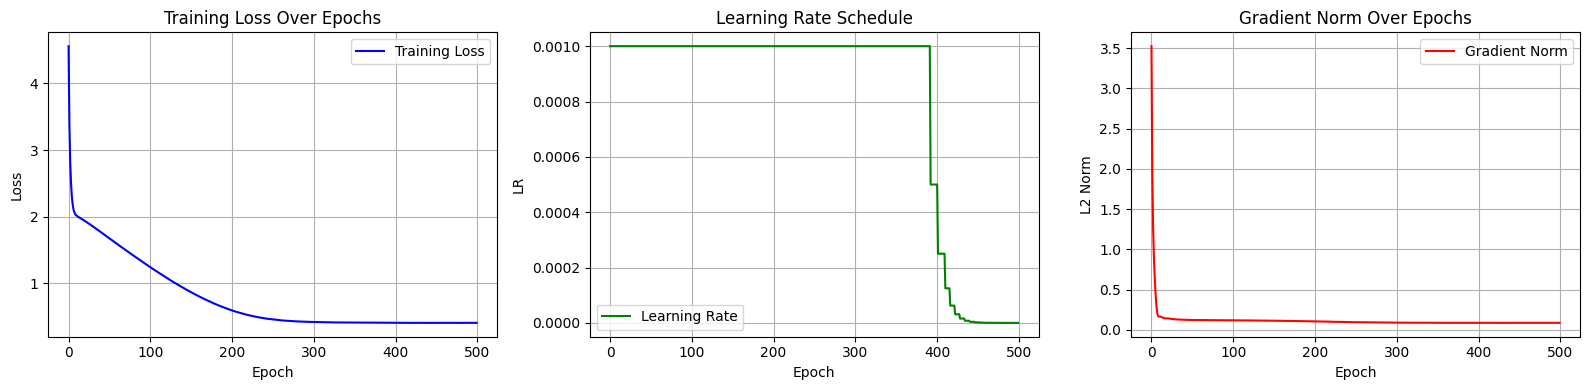

ANN Probe Evaluation: Test shape torch.Size([7180, 1536])
✅ Test Accuracy: 96.60%
Confusion Matrix:


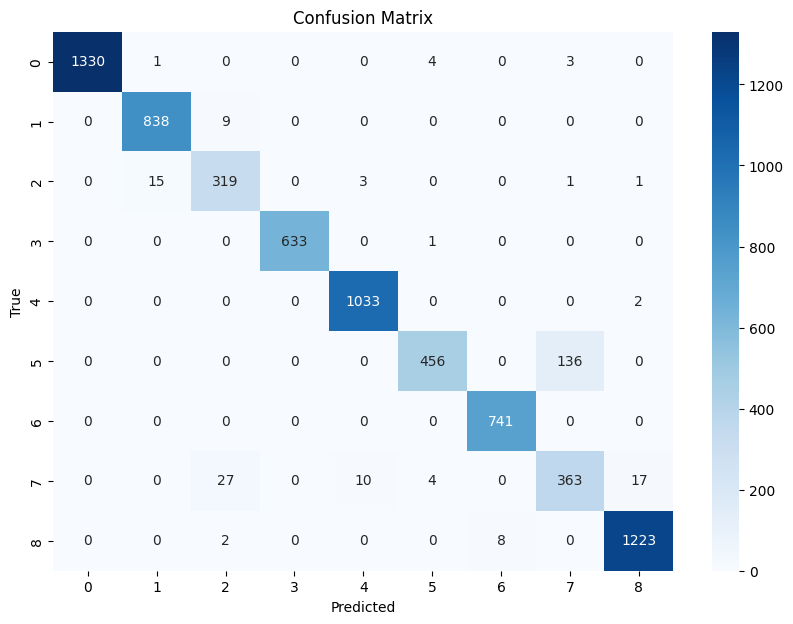

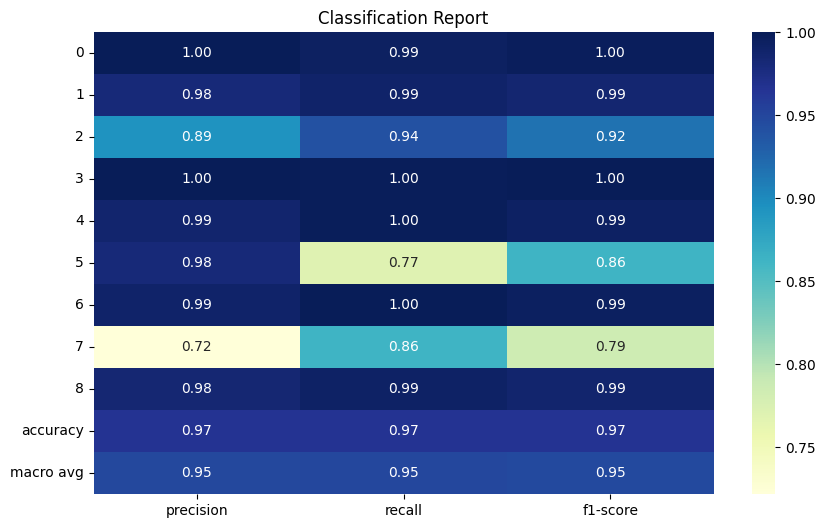

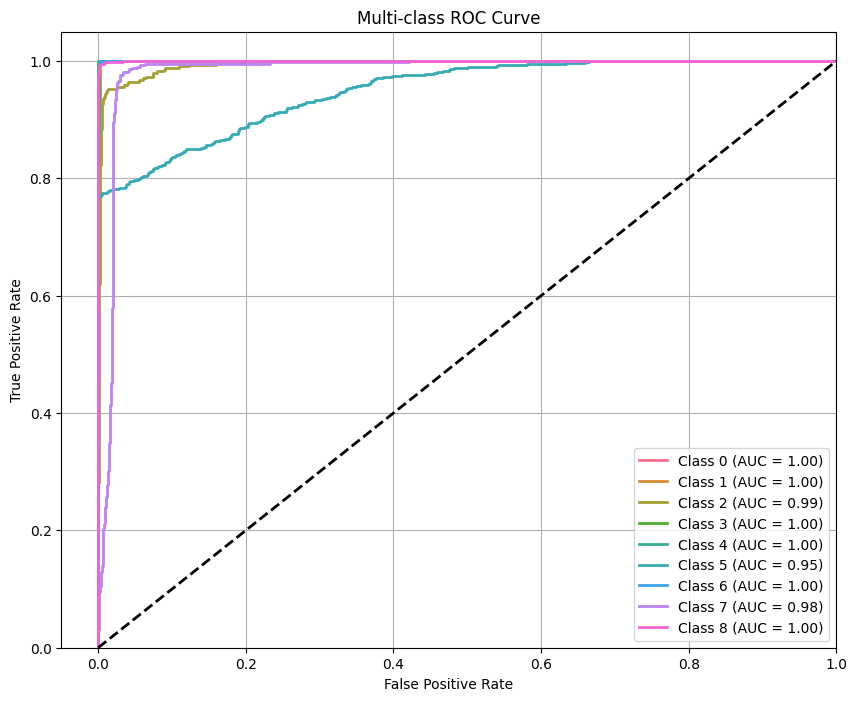

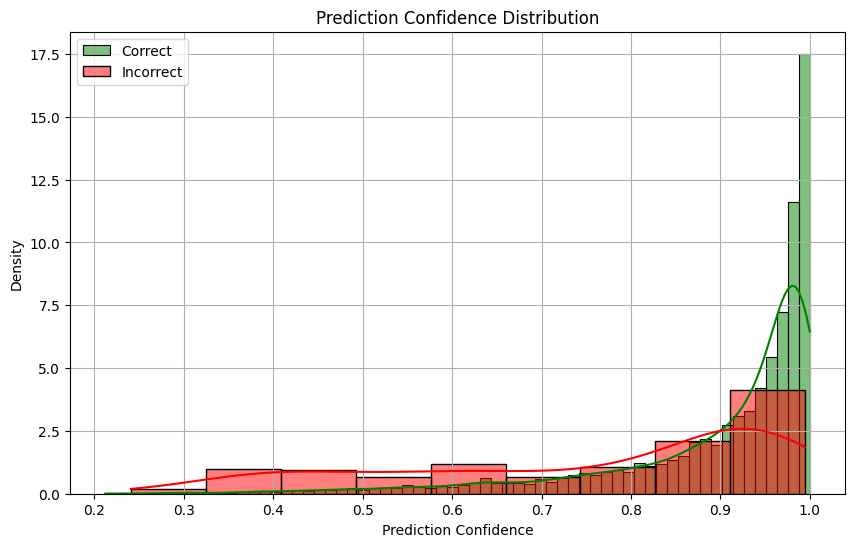

Model saved at: ./models/ann_crc100k_Hoptimus.pth
ANN Probe Evaluation: Time taken 11.68 and model saved : ./models/ann_crc100k_Hoptimus.pth


In [17]:
best_params, _ = ann_grid_search(
    train_feats=train_feats_hoptimus,
    train_labels=train_labels_hoptimus,
    test_feats=test_feats_hoptimus,
    test_labels=test_labels_hoptimus
)

import torch

# Train final model on full training set with best parameters
linprobe_eval_metrics, linprobe_dump = eval_ANN_probe(
    train_feats=train_feats_hoptimus,
    train_labels=train_labels_hoptimus,
    valid_feats=None,
    valid_labels=None,
    test_feats=test_feats_hoptimus,
    test_labels=test_labels_hoptimus,
    max_iter=best_params['max_iter'],
    hidden_dim1=best_params['hidden_dim1'],
    hidden_dim2=best_params['hidden_dim2'],
    C=best_params['C'],
    verbose=True,
    save_path='./models/ann_crc100k_Hoptimus.pth'
)

In [20]:
best_params

{'hidden_dim1': 256, 'hidden_dim2': 128, 'C': 10.0, 'max_iter': 500}

In [21]:
import json

with open('best_parameters/best_params_Hoptimus.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("✅ Saved best_params to best_params.json")

✅ Saved best_params to best_params.json
